In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Column, MaskedColumn, vstack
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import psfsubtraction.prepare.centering

%matplotlib inline

In [46]:
import ipyparallel

rc = ipyparallel.Client()
dview = rc[:]
lview = rc.load_balanced_view()

In [3]:
datadir = '/melkor/d1/guenther/obs/HST/Cepheids/snapshotprogram/'
outdir = '/melkor/d1/guenther/projects/Cepheids/HSTsnapshot/'

In [4]:
fitslist = glob(os.path.join(datadir, '?????????_drz.fits'))

F621Mfiles = np.array([f for f in fitslist if (fits.getval(f, 'FILTER') == 'F621M')])
F621Mnames = [fits.getval(f, 'TARGNAME') for f in F621Mfiles]
F621Mfiles = F621Mfiles[np.argsort(F621Mnames)]


F845Mfiles = np.array([f for f in fitslist if (fits.getval(f, 'FILTER') == 'F845M')])
F845Mnames = [fits.getval(f, 'TARGNAME') for f in F845Mfiles]
F845Mfiles = F845Mfiles[np.argsort(F845Mnames)]

In [5]:
def read_images(filelist, halfwidth):
    '''Read files, make header wrappers for WCS'''
    images = np.ma.zeros((2 * halfwidth + 1, 2 * halfwidth + 1, len(filelist)))
    targets = []

    for i, f in enumerate(filelist):
        hdus = fits.open(f)
        xm, ym = psfsubtraction.prepare.centering.center_from_spikes(hdus[1].data)
        targets.append(Cutout2D(hdus[1].data, (xm, ym), halfwidth, wcs=WCS(hdus[1].header)))
        xm = np.int(xm + 0.5)
        ym = np.int(ym + 0.5)
        images[:, :, i] = hdus[1].data[xm - halfwidth: xm+halfwidth + 1,
                                       ym - halfwidth: ym+halfwidth + 1]
        hdus.close()
    return images, targets


In [6]:
F621Marr, F621M = read_images(F621Mfiles, 50)
F845Marr, F845M = read_images(F845Mfiles, 50)

In [7]:
def mask_saturated(images, maskingfunc):
    '''Mask pixels above a certain value
   
    Parameters
    ----------
    image : np.array
        2d or 3d array of images (if 2d, then array of flattend images)
    maskingfunc : callable
        This function is called for every image. It returns as boolean mask
        that is ``True`` for all values that should be masked.
    '''
    for i in range(images.shape[-1]):
        images[maskingfunc(images[..., i]), i] = np.ma.masked
    return images

In [8]:
F621Marr = mask_saturated(F621Marr, lambda x: x > 0.6 * x.max())
F845Marr = mask_saturated(F845Marr, lambda x: x > 0.6 * x.max())

In [9]:
normF621 = np.ma.median(F621Marr.reshape((-1, F621Marr.shape[-1])), axis=0)
normF845 = np.ma.median(F845Marr.reshape((-1, F845Marr.shape[-1])), axis=0)

medianimF621 = np.ma.median(F621Marr.reshape((-1, F621Marr.shape[-1])), axis=1)
medianimF621 /= np.ma.median(medianimF621)
medianimF845 = np.ma.median(F845Marr.reshape((-1, F845Marr.shape[-1])), axis=1)
medianimF845 /= np.ma.median(medianimF845)

In [10]:
def apply_mediannorm(arr, normperim, normim):
    shape = arr.shape
    arr = arr.reshape((-1, shape[-1]))
    arr /= normperim[None, :]
    arr /= normim[:, None]
    return arr.reshape(shape)

def remove_mediannorm(arr, normperim, normim):
    shape = arr.shape
    arr = arr.reshape((-1, shape[-1]))
    arr *= normperim[None, :]
    arr *= normim[:, None]
    return arr.reshape(shape)

In [11]:
normF621 = apply_mediannorm(F621Marr.copy(), normF621, medianimF621)
normF845 = apply_mediannorm(F845Marr.copy(), normF845, medianimF845)

In [93]:
'''
Now, I run some examples with different parameters. 
I will compare them below (interactively by hand, not all plots are available in this notebook)
to determine the best parameters.

(Most of these calls can run on an engine in parallel.)
'''
# mask the bases with a stricter limit than the image data
# My idea is the following:
#    If the image data is bad, then there is nothing we can do about itb
#    but if the data in any base is bad, I can just not use that base for the pixel in question.
#    If we do us a signel bad base, that pixel is probably screwed up for the analysis, so it might be 
#    beneficial to use fewer bases when in doubt than risking a single base that is saturated.
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .4 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async1 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async2 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .8 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async3 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > 1 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async4 = lview.map_async(lambda x: x.remove_psf(), [f])

# Now, we repeat async2, but require a minimum number of bases. This is
# - faster (because fewer regions need to be evaluated)
# - fits that use just one or two bases are probably not very good anyway, so it might be better to have those
#   regions masked than to have bogus numbers in the result.
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
f.min_number_of_bases = 35
async5 = lview.map_async(lambda x: x.remove_psf(), [f])

# Repeat async2. Perform the subtraction on all pixels availble, but do *not* use the pixels
# very close to the center in the fitting.
# Because the class is defined interactively, I cannot easily ship it off to an engine.
# I can still wrap the result in a list, so that is looks the same as the async results.
import psfsubtraction.fitpsftemplates.fitregion
class fitter_except_center(psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction):
    fitregion = psfsubtraction.fitpsftemplates.fitregion.wrapper_fitmask(
                        psfsubtraction.fitpsftemplates.fitregion.all_unmasked)

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = fitter_except_center(normF621[..., 0], remove_img_from_psfbase(normF621.copy(), 0))
f.fitmask = np.max(F621_stricter_masking.mask.reshape((-1, 70)), axis=1)
async6 = [f.remove_psf()]

267


<matplotlib.colorbar.Colorbar instance at 0x7f804f6528c0>

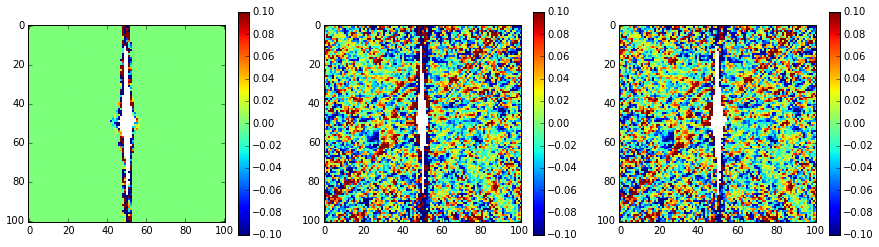

In [102]:
print len(f.regions())

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(async6[0] - async5.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(132)
im2 = ax2.imshow(async6[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(133)
im3 = ax3.imshow(async5.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im3, ax=ax3)
                                                                       

In [ ]:
'''
Comparing the experiements above by eye, I see that there is not obvious *best* solution,
e.g. comparing results 2 and 6, I see that the one works better on the left of the Cepheid, the other one on the
right side. One is slightly better in the center, the other one on the edge of the diffraction spikes.

Obviously, the results will also be slightly different for different images, but for those examples that I looked
at by eye it holds that differenes are small and there is no best solution.
Thus, I now pick, somewhat arbitrarily the parameters that will be applied to the full dataset:

Given that we don't loose much useful data, I will set min_number_of_bases = 35 which reduced runtime by about 50%.
Also, for simplicity, we'll use the same masks for data and bases.

'''

In [24]:
from psfsubtraction.fitpsftemplates.fitters import UseAllPixelsSubtraction as UAPS

def remove_img_from_psfbase(base, i):
    ind = np.ones(base.shape[-1], dtype=bool)
    ind[i] = False
    return base[..., ind]

F621inputs = [UAPS(normF621[..., i], remove_img_from_psfbase(normF621, i)) for i in range(normF621.shape[-1])]

for f in F621inputs:
    f.min_number_of_bases = 35


In [48]:
asyncres = lview.map_async(lambda x: x.remove_psf(), F621inputs[:5])

In [49]:
res = asyncres.get()

In [ ]:
# Vegamag zero points are here http://www.stsci.edu/hst/wfc3/phot_zp_lbn

# Units in image are electrons/s
# Images are drz -> drizzeled -> pixels are all same size.


def flux2magF621M(x):
    return -2.5 * np.log10(x) + 24.4539


def flux2magF845M(x):
    return -2.5 * np.log10(x) + 23.2809

In [ ]:







halfwidth = 50
daofindkwargs = {'fwhm': 1.5, 'threshold': 7, 'roundlo': -0.8, 'roundhi': 0.8}

fluxes, imout, scaledout = detection.photometryloop(images, targets, **daofindkwargs)
fluxes.add_column(MaskedColumn(flux2magF621M(fluxes['flux_fit']), 'mag_fit'))
fluxes.add_column(MaskedColumn(['F621M'] * len(fluxes), 'filter'))
#detection.plot_gallery('PSF subtr. - linear scale', imout, 10, 7, sources=fluxes)
#detection.plot_gallery('PSF subtr. - funny scale', scaledout, 10, 7, sources=fluxes)
# Get rid of negative fluxes. They must be fit artifacts
# Investigate later where they come from.
fluxes = fluxes[~fluxes['mag_fit'].mask]